# Reference points

Check if reference points have comparable positions among all structures.

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [1]:
from itertools import combinations
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd
import scipy

sys.path.append('../..')
from kinsim_structure.auxiliary import KlifsMoleculeLoader
from kinsim_structure.encoding import SpatialFeatures

In [4]:
pd.set_option('display.max_rows', 100)

## IO paths

In [5]:
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'projects' / 'kinsim_structure'
path_to_data = path_to_kinsim / 'examples'/ 'data'
path_to_results = path_to_kinsim / 'examples'/ 'results'

metadata_path = path_to_data / 'postprocessed' / 'klifs_metadata_postprocessed.csv'

## Load metadata

In [6]:
klifs_metadata = pd.read_csv(metadata_path)

## Get reference points

In [7]:
def get_reference_points(klifs_metadata):
    
    reference_points = {}

    for index, row in klifs_metadata.iterrows():

        ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
        spatial = SpatialFeatures()
        spatial.from_molecule(ml.molecule)

        ref = spatial.reference_points
        reference_points[row.metadata_index] = ref
        
    reference_points = pd.concat(reference_points, axis=0)
    reference_points.index.set_names(['id', 'coordinate'], inplace=True)
    
    return reference_points

In [8]:
reference_points = pd.read_csv(
    path_to_results / 'reference_points' / 'reference_points.csv',
    index_col=['id', 'coordinate']
)
print(reference_points.shape)
reference_points.head()

(11634, 4)


centroid  hinge_region  dfg_region  front_pocket
id    coordinate                                                   
2886  x            1.293375      1.976200    7.410200     -0.735833
      y           20.792858     21.758433   20.057467     15.892600
      z           36.404610     41.804733   33.520733     39.503467
10043 x            1.299501      2.009300    7.346733      0.313867
      y           21.195942     21.944700   20.813700     16.005333

## Distances

In [9]:
def get_pairwise_distances(points):
    """
    
    """

    pairwise_distances = []
    
    pairs = combinations(points.index, 2)
    print(f'Number of combinations: {len(list(pairs))}')
    print(list(pairs))
    
    for c1, c2 in pairs:
        

        distance = scipy.linalg.norm(points.loc[c1] - points.loc[c2])

        pairwise_distances.append([c1, c2, distance])

    return pd.DataFrame(
        pairwise_distances, 
        columns='centroid1_id centroid2_id distance'.split()
    )

### Intra-centroid distances

In [10]:
centroids = reference_points.centroid.unstack(level=1)
print(centroids.shape)
centroids.head()

(3878, 3)


coordinate,x,y,z
id,,,
2,1.059274,20.712621,37.372804
3,1.081872,20.655874,37.415106
6,1.201147,20.405920,37.057068
9,1.350751,20.973221,37.234519
12,1.076391,20.616362,37.040424


In [17]:
centroids.describe()

coordinate,x,y,z
count,3878.000000,3878.000000,3878.000000
mean,1.364375,20.990565,36.583153
std,0.401068,0.386672,0.491317
min,-1.466229,19.175228,33.732706
25%,1.092637,20.741963,36.233533
50%,1.353110,20.956650,36.482627
75%,1.622998,21.209738,36.914566
max,2.806138,23.238448,38.657924


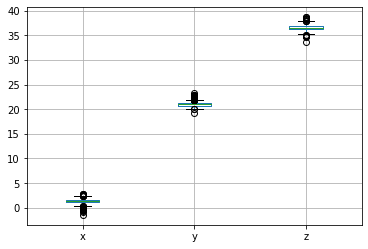

In [18]:
centroids.boxplot()

In [25]:
# Center centroids at mean centroid
centroids_centered = centroids.apply(lambda x: x - centroids.mean(), axis=1)

In [30]:
distance_centroids_centered = centroids_centered.apply(lambda x: scipy.linalg.norm(x), axis=1)

In [32]:
distance_centroids_centered.describe()

count    3878.000000
mean        0.663687
std         0.333420
min         0.043418
25%         0.416998
50%         0.631552
75%         0.854545
max         4.057242
dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b58003ba8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b57ff9908>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b58003588>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b57ff1668>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b57ff1cf8>],
 'means': []}

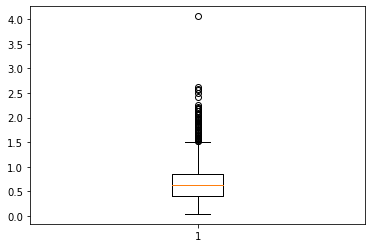

In [33]:
plt.boxplot(distance_centroids_centered)

### Centroid to other reference points distance

In [14]:
def get_distances_centroid2refpoint(refpoint_name):
    
    refpoint_centered = reference_points_centered[refpoint_name]
    refpoint_centered.dropna(inplace=True)
    
    d = refpoint_centered.unstack(level=1).apply(lambda x: scipy.linalg.norm(x), axis=1)
    
    return d

In [15]:
# Set centroid to origin
reference_points_centered = reference_points.apply(lambda x: x - reference_points.centroid)
print(reference_points_centered.shape)
reference_points_centered.head()

(11634, 4)


centroid  hinge_region  dfg_region  front_pocket
id    coordinate                                                  
2886  x                0.0      0.682825    6.116825     -2.029208
      y                0.0      0.965575   -0.735392     -4.900258
      z                0.0      5.400124   -2.883876      3.098857
10043 x                0.0      0.709799    6.047233     -0.985634
      y                0.0      0.748758   -0.382242     -5.190609


Distance from centroid to hinge_region
count    3876.000000
mean        5.612045
std         0.357220
min         3.237495
25%         5.388634
50%         5.582376
75%         5.839944
max         6.893033
dtype: float64


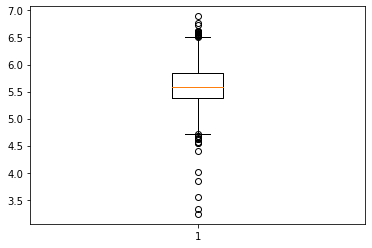


Distance from centroid to dfg_region
count    3868.000000
mean        7.031878
std         0.527511
min         5.495749
25%         6.653962
50%         6.965327
75%         7.425161
max         9.940150
dtype: float64


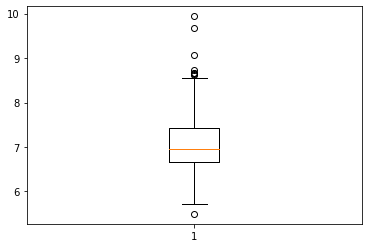


Distance from centroid to front_pocket
count    3745.000000
mean        5.913573
std         0.620292
min         3.962176
25%         5.531724
50%         5.894656
75%         6.220219
max        10.277790
dtype: float64


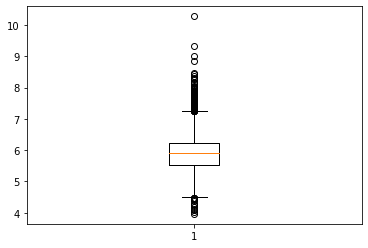

In [16]:
# Get norm of therese centered reference_points (= distance to centroid)

for refpoint_name in ['hinge_region', 'dfg_region', 'front_pocket']:
    
    distances = get_distances_centroid2refpoint(refpoint_name)
    
    print()
    print(f'Distance from centroid to {refpoint_name}')
    print(distances.describe())
    plt.boxplot(distances)
    plt.show()